In [40]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

<h1>Data Cleaning</h1>

In [2]:
# df = pd.read_csv("data.csv")

# https://www.kaggle.com/code/ybifoundation/purchase-prediction-micronumerosity/notebook
df = pd.read_csv('https://github.com/YBIFoundation/Dataset/raw/main/Customer%20Purchase.csv')

In [3]:
df.head()

,Customer ID,Age,Gender,Education,Review,Purchased
0,1021,30,Female,School,Average,No
1,1022,68,Female,UG,Poor,No
2,1023,70,Female,PG,Good,No
3,1024,72,Female,PG,Good,No
4,1025,16,Female,UG,Average,No


In [4]:
print(f"rows: {df.shape[0]}")
print(f"columns: {df.shape[1]}")

rows: 50
columns: 6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Customer ID  50 non-null     int64 
 1   Age          50 non-null     int64 
 2   Gender       50 non-null     object
 3   Education    50 non-null     object
 4   Review       50 non-null     object
 5   Purchased    50 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [6]:
df.nunique()

Customer ID    50
Age            41
Gender          2
Education       3
Review          3
Purchased       2
dtype: int64

In [7]:
df.describe()

,Customer ID,Age
count,50.00000,50.000000
mean,1045.50000,54.160000
std,14.57738,25.658161
min,1021.00000,15.000000
25%,1033.25000,30.250000
50%,1045.50000,57.000000
75%,1057.75000,74.000000
max,1070.00000,98.000000


In [8]:
df = df.drop(["Customer ID"], axis=1)

<h2>Missing Value</h2>

In [9]:
df.isnull().sum()

Age          0
Gender       0
Education    0
Review       0
Purchased    0
dtype: int64

<h1>EDA</h1>

In [10]:
(df["Purchased"] == "Yes").sum() / df.shape[0]

np.float64(0.48)

In [11]:
def show_numeric(numeric_cols, n_cols=2):
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4))
    axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i], color='skyblue')
        axes[i].set_title(col, fontsize=12)

    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

In [12]:
numeric_cols = df.select_dtypes(include=np.number).columns

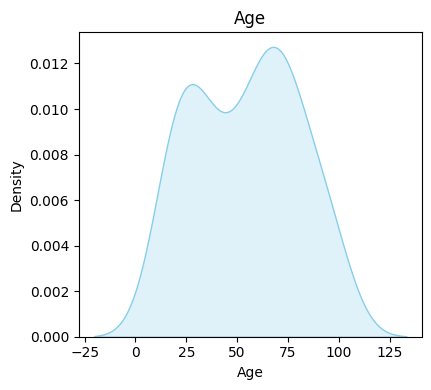

In [13]:
show_numeric(numeric_cols)

In [14]:
def show_numeric_with_target(numeric_cols, n_cols=3):
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4))
    axes = axes.flatten()

    
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x='Purchased', y=col, data=df, ax=axes[i],  color='skyblue')
        # sns.regplot(data=df, x=col, y='G3', ax=axes[i],
        #             scatter_kws={'alpha':0.5, 's':40},
        #             line_kws={'color':'red'}, color='skyblue')
        axes[i].set_xlabel("Purchased")
        axes[i].set_ylabel("Age")
    
    # Remove unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

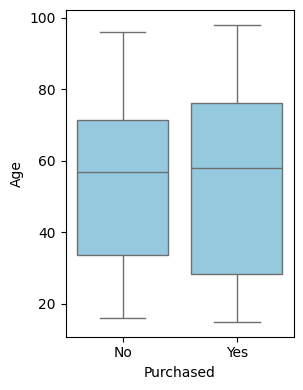

In [15]:
show_numeric_with_target(numeric_cols)

In [16]:
def show_categorical(categorical_cols, n_cols=2):
    n_rows = int(np.ceil(len(categorical_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        sns.countplot(data=df, x=col, ax=axes[i],
                      order=df[col].value_counts().index, color='skyblue')
        axes[i].set_title(col, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

In [17]:
categorical_cols = df.select_dtypes(include='object').columns

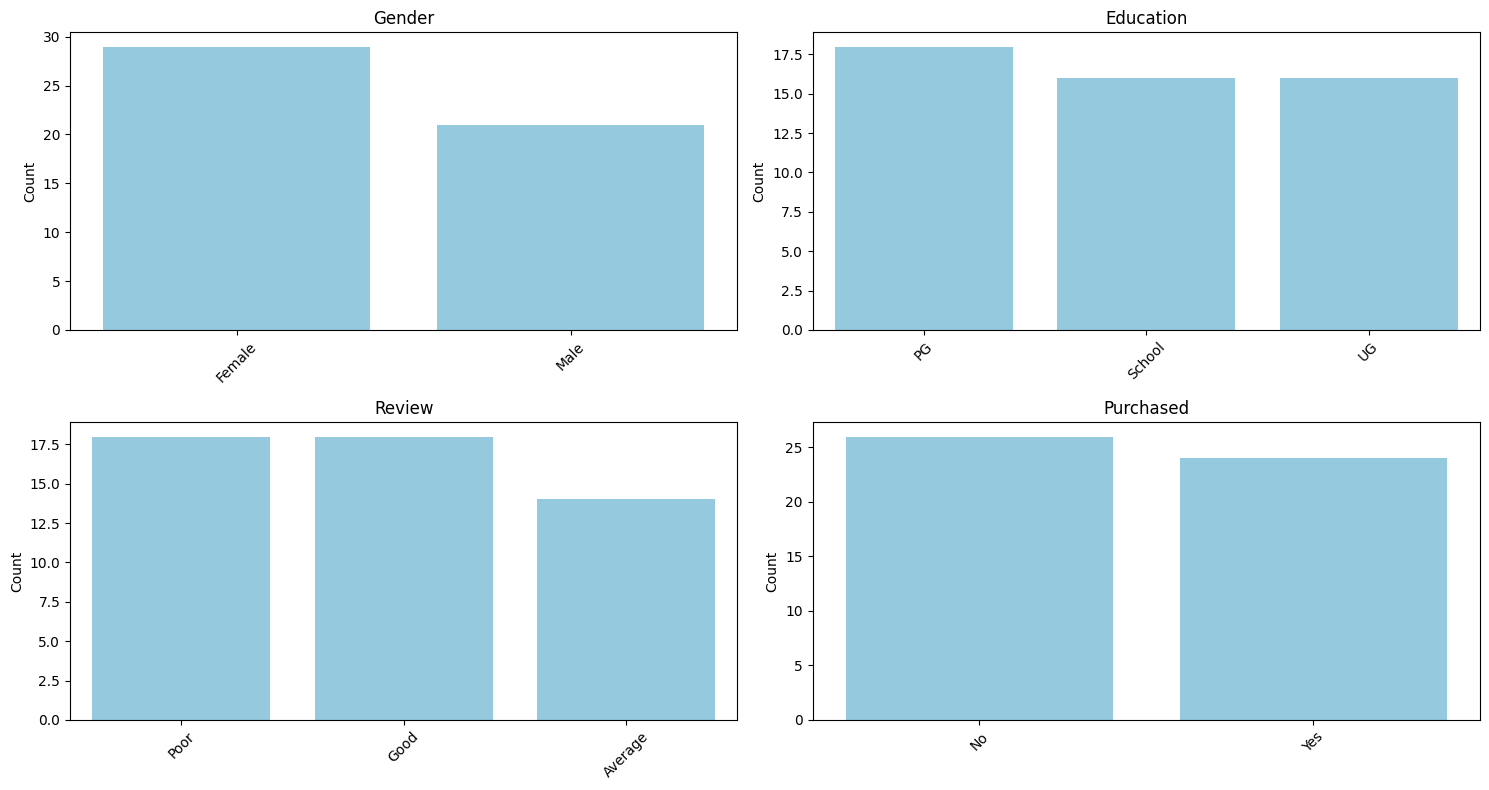

In [18]:
show_categorical(categorical_cols)

In [19]:
def show_categorical_with_target(categorical_cols, n_cols=2):
    n_rows = int(np.ceil(len(categorical_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axes = axes.flatten()

    cols = []
    for col in categorical_cols:
        if col != "Purchased":
            cols.append(col)
    
    for i, col in enumerate(cols):
        sns.countplot(data=df, x=col, ax=axes[i],
                      order=df[col].value_counts().index, hue="Purchased", palette="dark:skyblue")
        axes[i].set_title(col, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

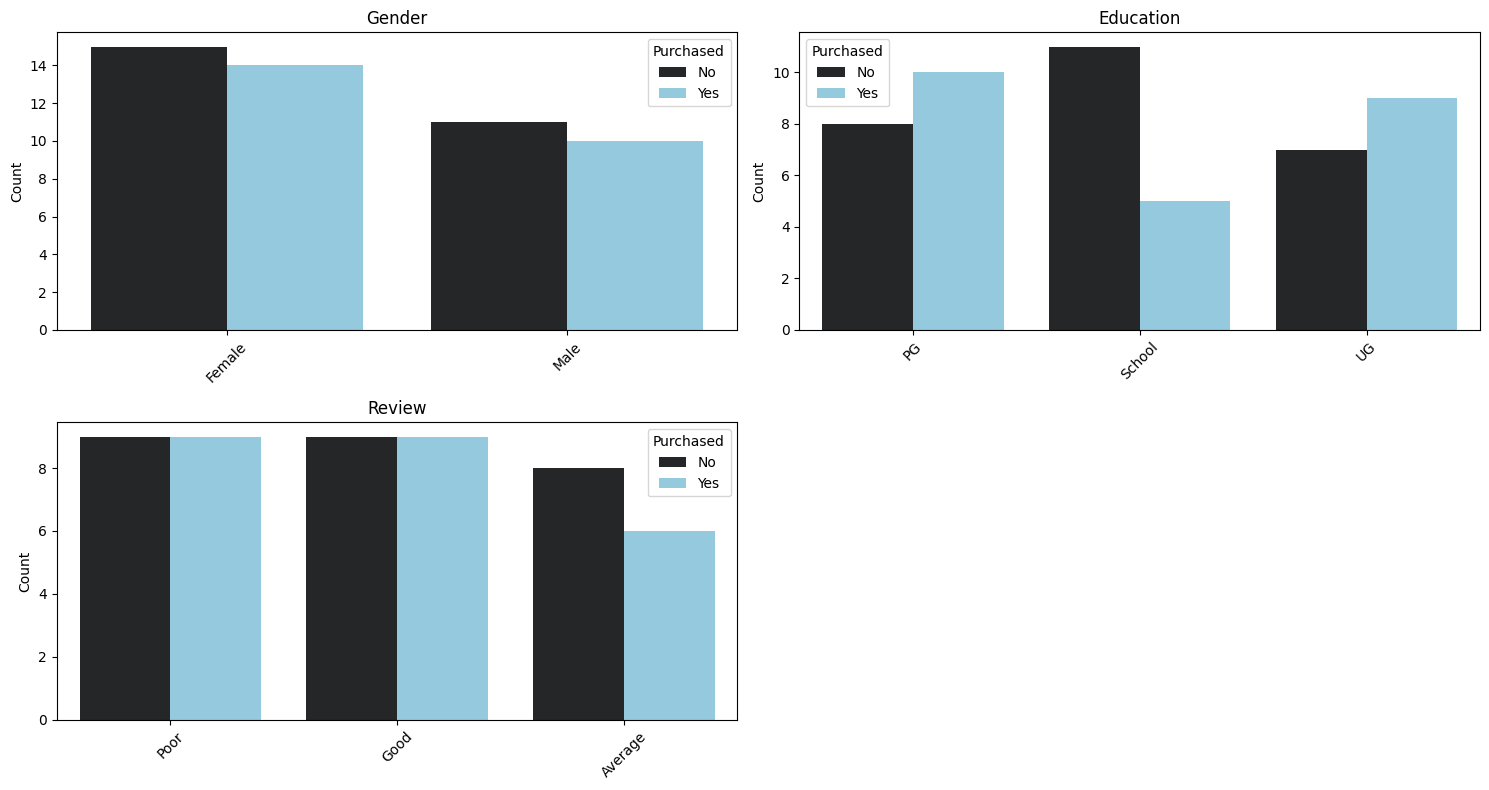

In [20]:
show_categorical_with_target(categorical_cols)

<h1>Preprocessing</h1>

In [21]:
review_mapping = {"Poor": 0, "Average": 1, "Good": 2}

df["review_score"] = df["Review"].map(review_mapping)

In [22]:
df["Purchased"] = df["Purchased"].map({"Yes": 1, "No": 0})

In [23]:
df_encoded = pd.get_dummies(df, columns=["Gender", "Education"], drop_first=True)

In [24]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               50 non-null     int64 
 1   Review            50 non-null     object
 2   Purchased         50 non-null     int64 
 3   review_score      50 non-null     int64 
 4   Gender_Male       50 non-null     bool  
 5   Education_School  50 non-null     bool  
 6   Education_UG      50 non-null     bool  
dtypes: bool(3), int64(3), object(1)
memory usage: 1.8+ KB


In [25]:
X_full = df_encoded.drop(["Purchased", "Review"], axis=1)
y_full = df_encoded["Purchased"]

In [26]:
def normalize_col(col):
    X_full[col]=(X_full[col]-X_full[col].mean())/X_full[col].std()

In [27]:
for col in X_full.columns:
    normalize_col(col)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (40, 5)
Test set shape: (10, 5)


In [58]:
columns = X_train.columns

<h1>Models</h1>

In [29]:
X_train.head()

,Age,review_score,Gender_Male,Education_School,Education_UG
16,0.188634,-1.166667,1.163329,-0.679100,1.443087
13,0.110686,0.000000,-0.842410,1.443087,-0.679100
47,-0.629819,1.166667,-0.842410,-0.679100,-0.679100
27,0.578373,-1.166667,-0.842410,-0.679100,-0.679100
2,0.617347,1.166667,-0.842410,-0.679100,-0.679100


In [30]:
y_train.head()

16    1
13    0
47    1
27    0
2     0
Name: Purchased, dtype: int64

In [60]:
def evaluate(y_label, y_pred, show_confusion_m=False):
    print("Accuracy:", accuracy_score(y_label, y_pred))
    print("\nClassification Report:\n", classification_report(y_label, y_pred, zero_division=0))
    
    if show_confusion_m:
        cm_lr = confusion_matrix(y_label, y_pred)
        sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

def evaluate_model(model, show_confusion_m=False):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("\nTraining\n")
    evaluate(y_train, y_pred_train, show_confusion_m)

    print("\nTest\n")
    evaluate(y_test, y_pred_test, show_confusion_m)


def find_and_evaluate_best(model, param_grid, is_regression_model=False):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation F1 Score:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    if is_regression_model:
        evaluate_regression_model(best_model)
    else:
        evaluate_model(best_model)

    return best_model

def plot_precision_recall(model, predict_prob):
    steps = 20
    d = 1 / 20
    y_pred_prob = predict_prob(model, X_test)
    precision = []
    recall = []
    f1 = []
    for inc in range(20):
        threshold = (inc + 1) * d
        y_pred = np.where(y_pred_prob < threshold, 0, 1)
        precision.append(precision_score(y_test, y_pred, average=None, zero_division=0)[1])
        recall.append(recall_score(y_test, y_pred, average=None, zero_division=0)[1])
        f1.append(f1_score(y_test, y_pred, average=None, zero_division=0)[1])

    
    best_index = np.argmax(f1)
    best_threshold = (best_index + 1) * d
    
    thresholds = np.linspace(1/20, 1, 20)

    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='s')
    plt.plot(thresholds, f1, label='F1', marker='o')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    plt.show()

    print(f"{'Best Threshold for F1':<25} {best_threshold:.3f}")
    print(f"{'Best F1':<25} {f1[best_index]:.3f}")
    print(f"{'Best Recall':<25} {recall[best_index]:.3f}")
    print(f"{'Best Precision':<25} {precision[best_index]:.3f}")

def plot_feature_importance(importances):
    df_feature = pd.DataFrame({'Feature': columns, 'Importance': importances})
    df_feature = df_feature.sort_values(by='Importance', ascending=True)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.barh(df_feature['Feature'], df_feature['Importance'], color='forestgreen')
    plt.xlabel('Feature Importance')
    plt.show()

<h2>Logistic Regression</h2>

In [32]:
from sklearn.linear_model import LogisticRegression

model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

LogisticRegression()

In [33]:
def predict_prob_logistic(model, X_test):
    return model.predict_proba(X_test)[:, 1]

In [34]:
evaluate_model(model_logistic)


Training

Accuracy: 0.625

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.52      0.59        21
           1       0.58      0.74      0.65        19

    accuracy                           0.62        40
   macro avg       0.64      0.63      0.62        40
weighted avg       0.64      0.62      0.62        40


Test

Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.50      0.40      0.44         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10



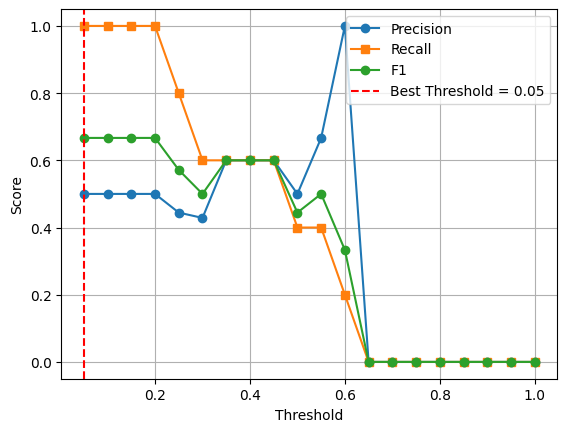

Best Threshold for F1     0.050
Best F1                   0.667
Best Recall               1.000
Best Precision            0.500


In [37]:
plot_precision_recall(model_logistic, predict_prob_logistic)

<h3>CV Best Parameters</h3>

In [44]:
pipe_logistic = Pipeline([
    ('log_reg', LogisticRegression(max_iter=1000, solver='liblinear'))
])
param_grid_logistic = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2'],
    'log_reg__solver': ['liblinear'] 
}
model_logistic_best = find_and_evaluate_best(pipe_logistic, param_grid_logistic)

Best Parameters: {'log_reg__C': 0.1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}
Best Cross-Validation F1 Score: 0.5271428571428571

Training

Accuracy: 0.625

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.52      0.59        21
           1       0.58      0.74      0.65        19

    accuracy                           0.62        40
   macro avg       0.64      0.63      0.62        40
weighted avg       0.64      0.62      0.62        40


Test

Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.50      0.40      0.44         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10



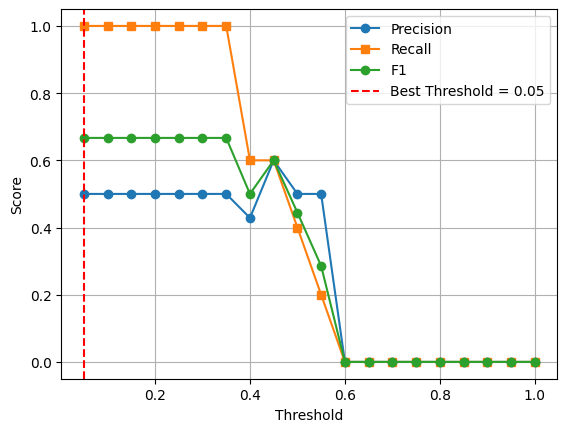

Best Threshold for F1     0.050
Best F1                   0.667
Best Recall               1.000
Best Precision            0.500


In [45]:
plot_precision_recall(model_logistic_best, predict_prob_logistic)

<h3>Interpretation</h3>

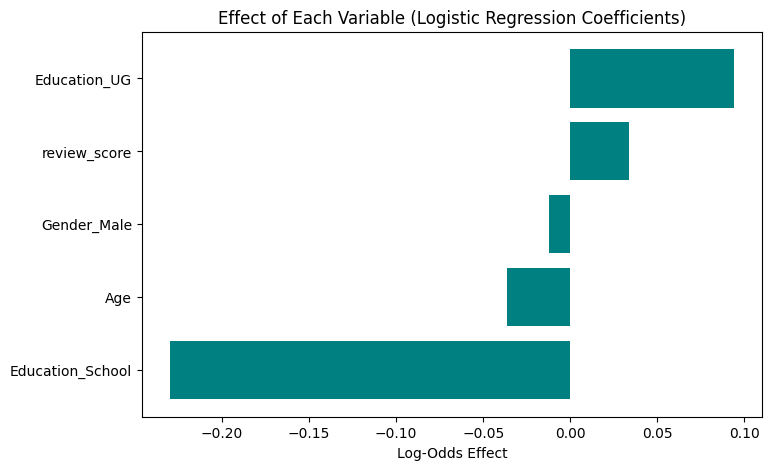

In [59]:
model_logistic_best_model = model_logistic_best.named_steps['log_reg']

coefficients_logistic = model_logistic_best_model.coef_[0]
columns = X_train.columns

coef_df_logistic = pd.DataFrame({'feature': columns, 'coefficient': coefficients_logistic})

coef_df_logistic = coef_df_logistic.sort_values(by='coefficient', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(coef_df_logistic['feature'], coef_df_logistic['coefficient'], color='teal')
plt.xlabel('Log-Odds Effect')
plt.title('Effect of Each Variable (Logistic Regression Coefficients)')
plt.gca().invert_yaxis()  # largest effect on top
plt.show()

<h2>Decision Tree</h2>

In [46]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(
    criterion='gini',       
    max_depth=6,           
    min_samples_split=10,
    random_state=42
)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=10, random_state=42)

In [47]:
evaluate_model(model_tree)


Training

Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.90      0.79        21
           1       0.85      0.58      0.69        19

    accuracy                           0.75        40
   macro avg       0.77      0.74      0.74        40
weighted avg       0.77      0.75      0.74        40


Test

Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       0.00      0.00      0.00         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



In [48]:
pipe_tree = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=42),)
])
param_grid_tree = {
    'tree__max_depth': [3, 5, 7, 9, None],
    'tree__min_samples_split': [2, 5, 10, 20],
    'tree__min_samples_leaf': [1, 5, 10],
    'tree__criterion': ['gini', 'entropy']
}
model_tree_best = find_and_evaluate_best(pipe_tree, param_grid_tree)

Best Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 9, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 2}
Best Cross-Validation F1 Score: 0.5922222222222222

Training

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Test

Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



In [50]:
from sklearn.tree import plot_tree

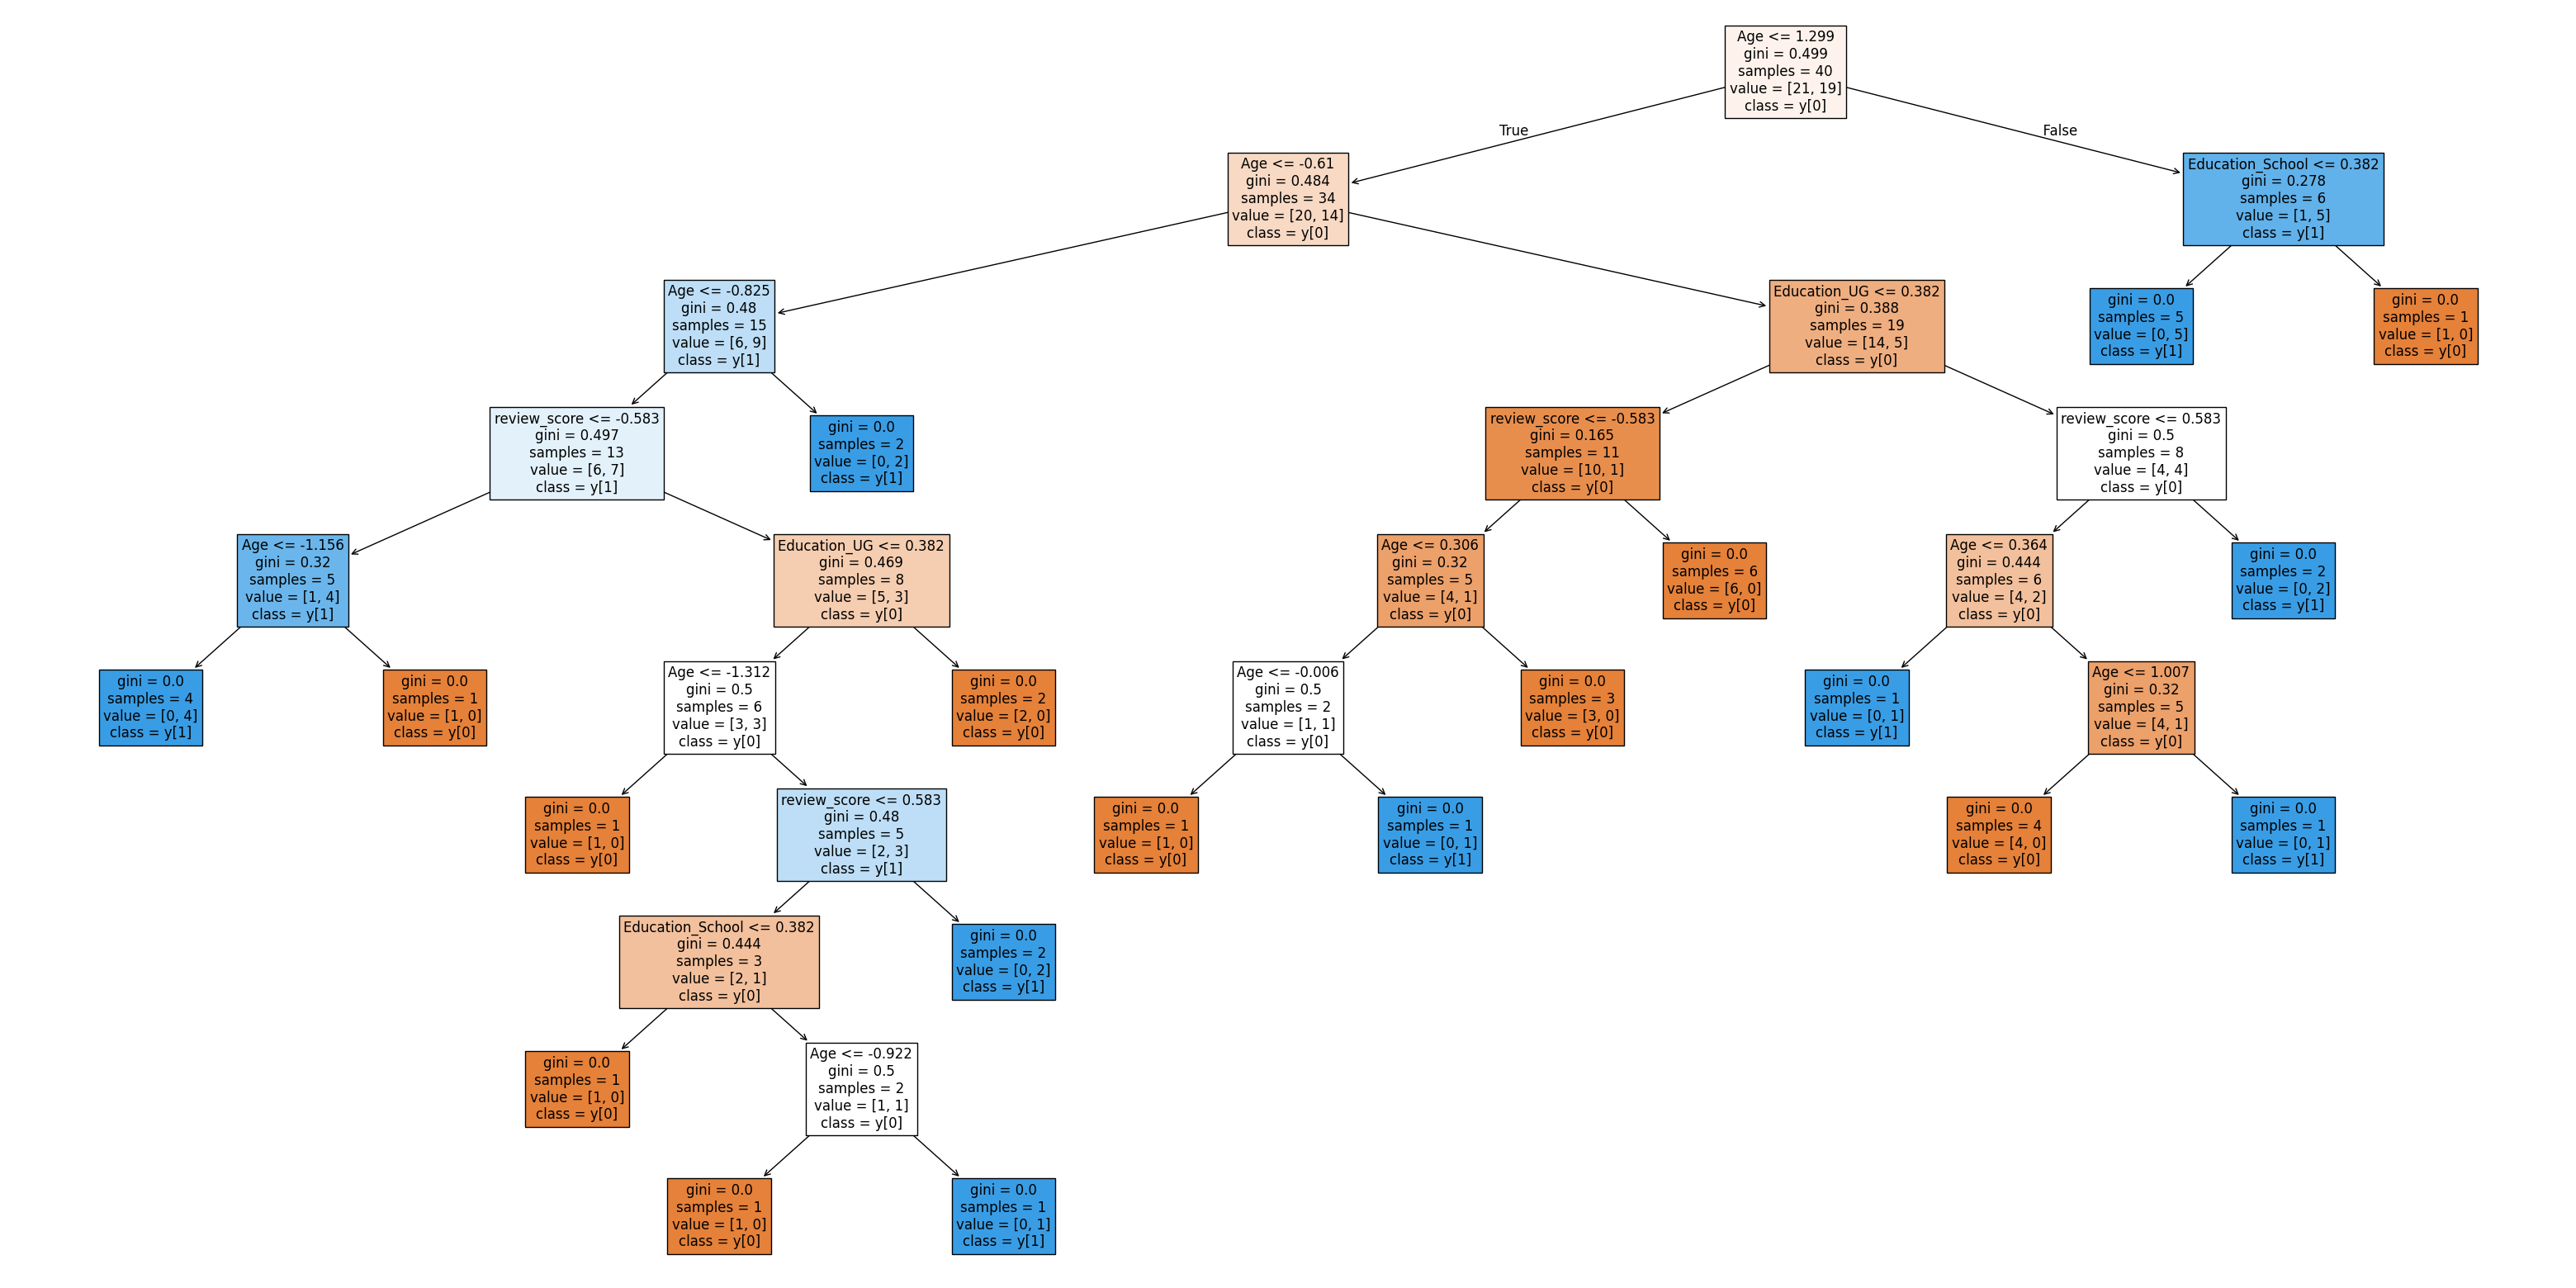

In [51]:
model_tree_best_model = model_tree_best.named_steps['tree']

plt.figure(figsize=(40, 20))
plot_tree(model_tree_best_model, filled=True, feature_names=X_train.columns, class_names=True, fontsize=12 )
plt.show()

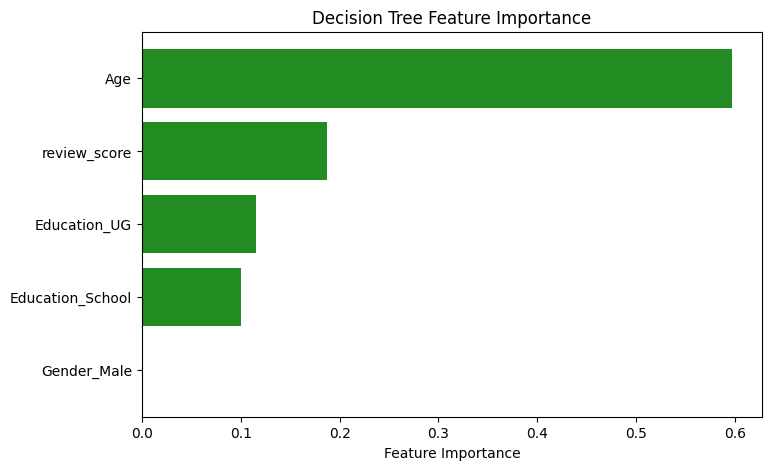

In [61]:
plot_feature_importance(model_tree_best_model.feature_importances_)

<h3>XGBoost</h3>

In [62]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
)
model_xgb.fit(X_train, y_train)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [65]:
def predict_prob_xgb(model, X_test):
    return model.predict_proba(X_test)[:, 1]

In [63]:
evaluate_model(model_xgb)


Training

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Test

Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.50      0.20      0.29         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.45        10
weighted avg       0.50      0.50      0.45        10



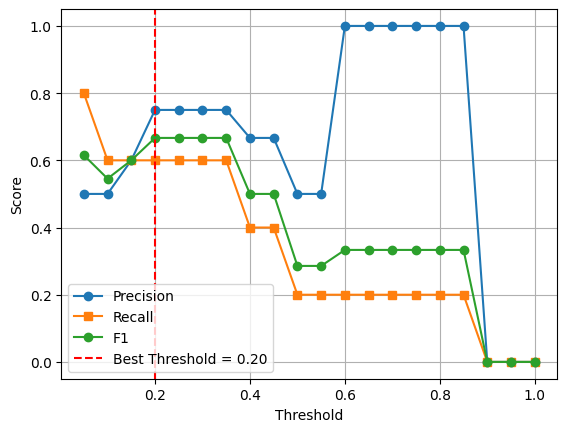

Best Threshold for F1     0.200
Best F1                   0.667
Best Recall               0.600
Best Precision            0.750


In [66]:
plot_precision_recall(model_xgb, predict_prob_logistic)

In [67]:
pipe_xgb = Pipeline([
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    ))
])
param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__scale_pos_weight': [1, 2, 5]  # can help for imbalance
}
model_sgb_best = find_and_evaluate_best(pipe_xgb, param_grid_xgb)

Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__scale_pos_weight': 2, 'xgb__subsample': 0.8}
Best Cross-Validation F1 Score: 0.6666666666666666

Training

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Test

Accuracy: 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



In [68]:
model_sgb_best_model = model_sgb_best.named_steps['xgb']

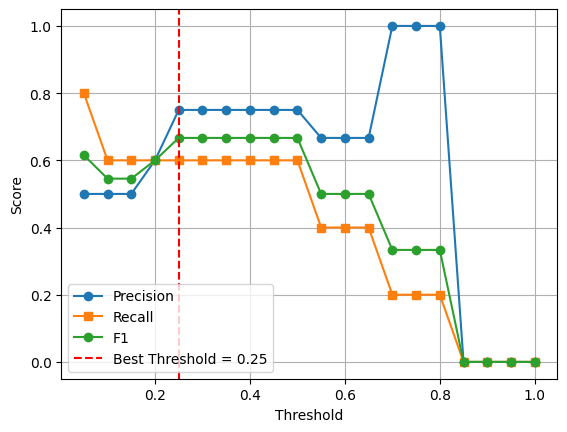

Best Threshold for F1     0.250
Best F1                   0.667
Best Recall               0.600
Best Precision            0.750


In [69]:
plot_precision_recall(model_sgb_best_model, predict_prob_logistic)

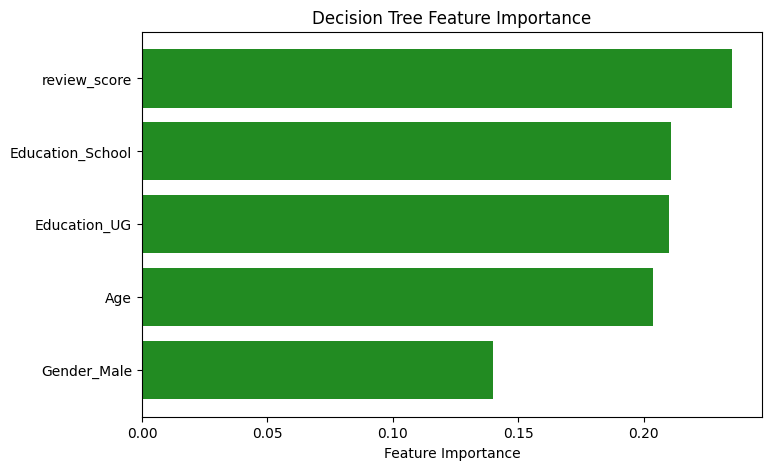

In [70]:
plot_feature_importance(model_sgb_best_model.feature_importances_)